In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [4]:
# load dataset
dataset = pd.read_excel('data.xlsx')

In [5]:
dataset.shape

(19285, 515)


Compute the Risky asset and the riskless assets for all the individuals in the survey data. Risky and riskless assets are defined as follows:

Risky assets is investments in mutual funds, stocks, bonds, commodities, and
real estate, and an estimate of human capital.

Risk Free Assets: checking and savings balances,certificates of deposit, and other cash balances and equivalents.
We take the ratio of risky assets to total assets of an investor and consider that as a measure of risk tolerance of an investor. From the data of SCF, we have the data of risky and riskless assets for the individuals for 2007 and 2009. We use this data and normalise the risky assets with the stock price of 2007 vs. 2009 to get risk tolerance.
Risk Tolerance just defined as the ratio of Risky Asset to Riskless Assets normalised with the average S&P500 of 2007 vs 2009.

Average S&P500 in 2007: 1478 Average S&P500 in 2009: 948

Risk-Free: Sum of different risk-free assets , such as liquid assets (LIQ), credit default swaps (CDS), savings bonds (SAVBND), and cash-like assets (CASHLI).

Risky: Sum of various risky assets in, including money market funds (NMMF), stocks (STOCKS), and bonds (BOND).

In [10]:
#Average SP500 during 2007 and 2009
Average_SP500_2007 = 1478
Average_SP500_2009 = 948

#Risk Tolerance 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

#Risk Tolerance 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [11]:
dataset2 = copy.deepcopy(dataset)
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


percentage change in risk tolerance between 2007 and 2009

In [13]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

In [14]:
# Drop the rows containing NA
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

In [15]:
print('Null Values =',dataset2.isnull().values.any())

Null Values = False


plot the risk tolerance of 2007 and 2009.

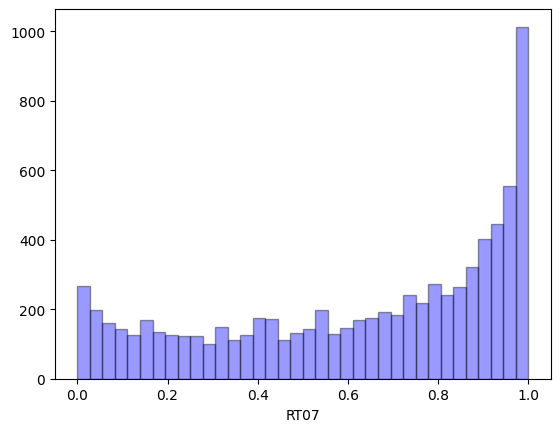

In [17]:
sns.distplot(dataset2['RT07'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'});

Looking at the risk tolerance of 2007, we see that a significant number of individuals had risk tolerance close to one.Meaning the investment ws more skewed towards the risky assets as compared to the riskless assets.

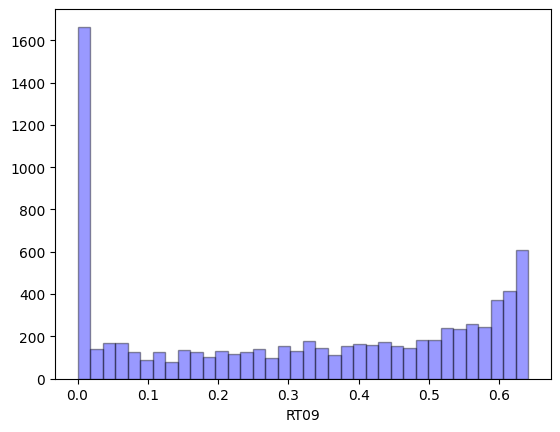

In [18]:
sns.distplot(dataset2['RT09'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'});

The behavior of the individuals reversed in 2009 after crisis and majority of the investment was in risk free assets. Overall risk tolerance decreased, which is shown by majority of risk tolerance being close to 0 in 2009.

In [19]:
dataset3 = copy.deepcopy(dataset2)

Investors whose risk tolerance change between 2007 and 2009 was less than 10%

In [20]:
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

We assign the true risk tolerance as the average risk tolerance of these intelligent investors between 2007 and 2009. This is the predicted variable for this case study. The purpose would be to predict the true risk tolerance of an individuals given the demographic, financial and willingness to take risk related features.

In [21]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

In [22]:
# drop unnecessary labels
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

## Feature Elimination:

In order to filter the features further we do the following:

Check the description in the Data Dictionary (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt)and only keep the features that are intuitive
The description is as follows:

AGE: There are 6 age categories, where 1 represents age less than 35 and 6 represents age more than 75.

EDUC: There are 4 education categories, where 1 represents no high school and 4 represents college degree.

MARRIED: It represents marital status. There are two categories where 1 represents married and 2 represents unmarried.

OCCU: It represents occupation category. 1 represents managerial category and 4 represents unemployed.

KIDS: It represents number of kids.
NWCAT: It represents net worth category. There are 5 categories, where 1 net worth less than 25 percentile and 5 represents net worth more than 90th percentile.

INCCL: It represents income category. There are 5 categories, where 1 income less than 10,000 and 5 represents net worth more than 100,000

RISK: It represents the willingness to take risk on a scale of 1 to 4, where 1 represents highest level of willingness to take risk.

Keep only the intuitive factors as of 2007 only and remove all the intermediate features and features related to 2009, as the variables of 2007 are the only ones required for predicting the risk tolerance.

In [23]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance'
]

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

In [28]:
dataset3.head()

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerance
60,77,2,1,0,3,3.141680e+04,4,2.152490e+05,0.199511
425,55,4,1,1,2,2.779588e+06,2,4.964759e+07,0.641458
1122,85,4,1,0,2,3.727417e+05,4,5.837768e+07,0.589943
1190,40,2,1,3,1,5.324882e+04,3,2.688929e+05,0.434127
1228,70,2,1,0,2,3.716767e+04,3,2.015066e+06,0.228218


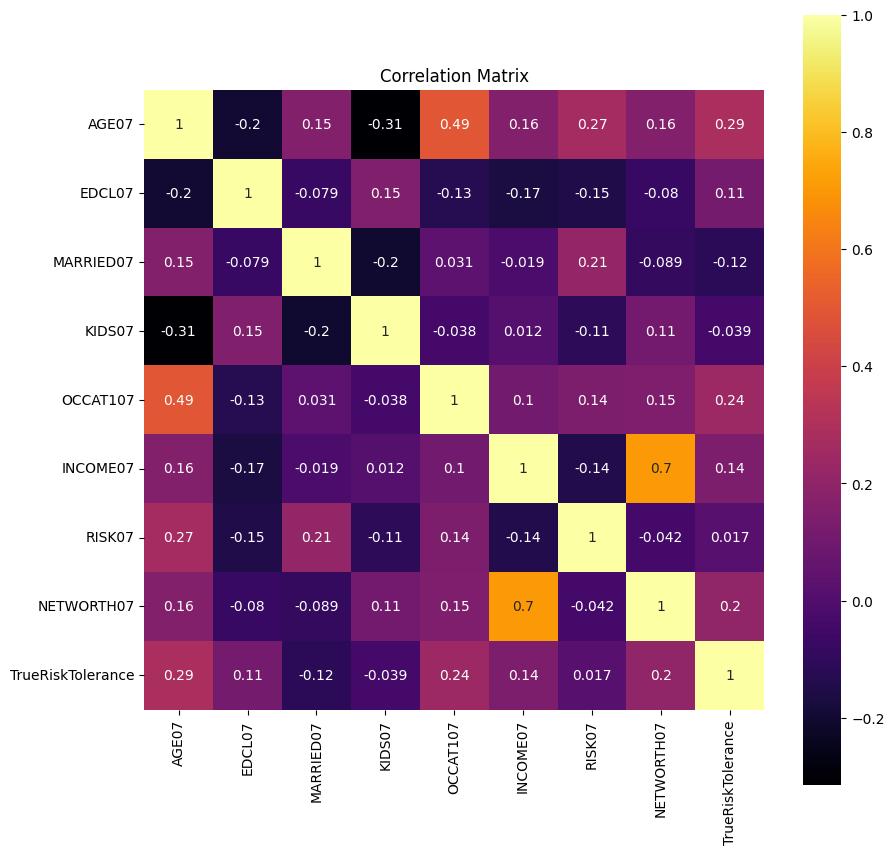

In [27]:
# correlation among features

correlation = dataset3.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='inferno');

Looking at the correlation chart above, networth and income are positively correlated with the risk tolerance. With more number of kids and marriage the risk tolerance decreases. As the willingness to take risk decreases the risk tolerance decreases. With age there is a positive relationship of the risk tolerance.

In [43]:
dataset3.info

<bound method DataFrame.info of        AGE07  EDCL07  MARRIED07  KIDS07  OCCAT107      INCOME07  RISK07  \
60        77       2          1       0         3  3.141680e+04       4   
425       55       4          1       1         2  2.779588e+06       2   
1122      85       4          1       0         2  3.727417e+05       4   
1190      40       2          1       3         1  5.324882e+04       3   
1228      70       2          1       0         2  3.716767e+04       3   
...      ...     ...        ...     ...       ...           ...     ...   
19190     53       4          1       0         1  1.810460e+05       2   
19191     53       4          1       0         1  1.821109e+05       2   
19192     53       4          1       0         1  1.810460e+05       2   
19193     53       4          1       0         1  1.810460e+05       2   
19194     53       4          1       0         1  1.821109e+05       2   

         NETWORTH07  TrueRiskTolerance  
60     2.152490e+05       

# Modelling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [30]:
# split out validation dataset for the end
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [31]:
# test options for regression
num_folds = 10
scoring = 'r2'

## Compare different models

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [33]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))
#Ensable Models
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

k-fold cross validation

In [35]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.105127 (0.103969)
LASSO: -0.023692 (0.118324)
EN: -0.031108 (0.117770)
KNN: -0.409466 (0.166879)
CART: -0.610731 (0.195349)
SVR: -0.101482 (0.092744)
ABR: -0.382390 (0.068271)
GBR: -0.653019 (0.104185)
RFR: -0.738529 (0.072908)
ETR: -0.750014 (0.113808)


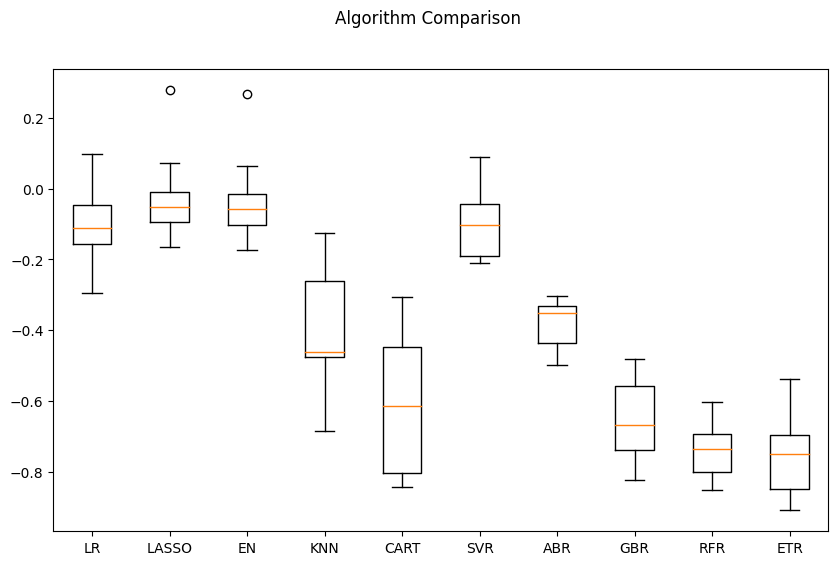

In [37]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(10,6)
plt.show()

The non linear models perform better than the linear models, which means that a non linear relationship between the risk tolerance and the difference variables use to predict it. Given random forest regression is one of the best methods, we use it for further grid search.

## Model Tuning and Grid Search

In [39]:
# Grid search : RandomForestRegressor
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.736340 using {'n_estimators': 150}
0.732511 (0.096521) with: {'n_estimators': 50}
0.723788 (0.089027) with: {'n_estimators': 100}
0.736340 (0.083578) with: {'n_estimators': 150}
0.733354 (0.085853) with: {'n_estimators': 200}
0.732660 (0.086404) with: {'n_estimators': 250}
0.736139 (0.080244) with: {'n_estimators': 300}
0.730507 (0.080771) with: {'n_estimators': 350}
0.735878 (0.080719) with: {'n_estimators': 400}


## Final Model

In [40]:
# prepare model
model = RandomForestRegressor(n_estimators = 250)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=250)

In [41]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9625609339324688


In [42]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.0072432923643041035
0.7779585359877188
